In [1]:
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
%pylab inline

import pickle as pkl
from itertools import islice
import datetime
import random
import itertools
import glob
import pickle as pkl
import time
import os
import fancyimpute, impyute

from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input
from keras.optimizers import SGD, Adam
from keras.utils import plot_model

from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

rootPath = '../IMDA/'


Populating the interactive namespace from numpy and matplotlib


/Users/phuw273g/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


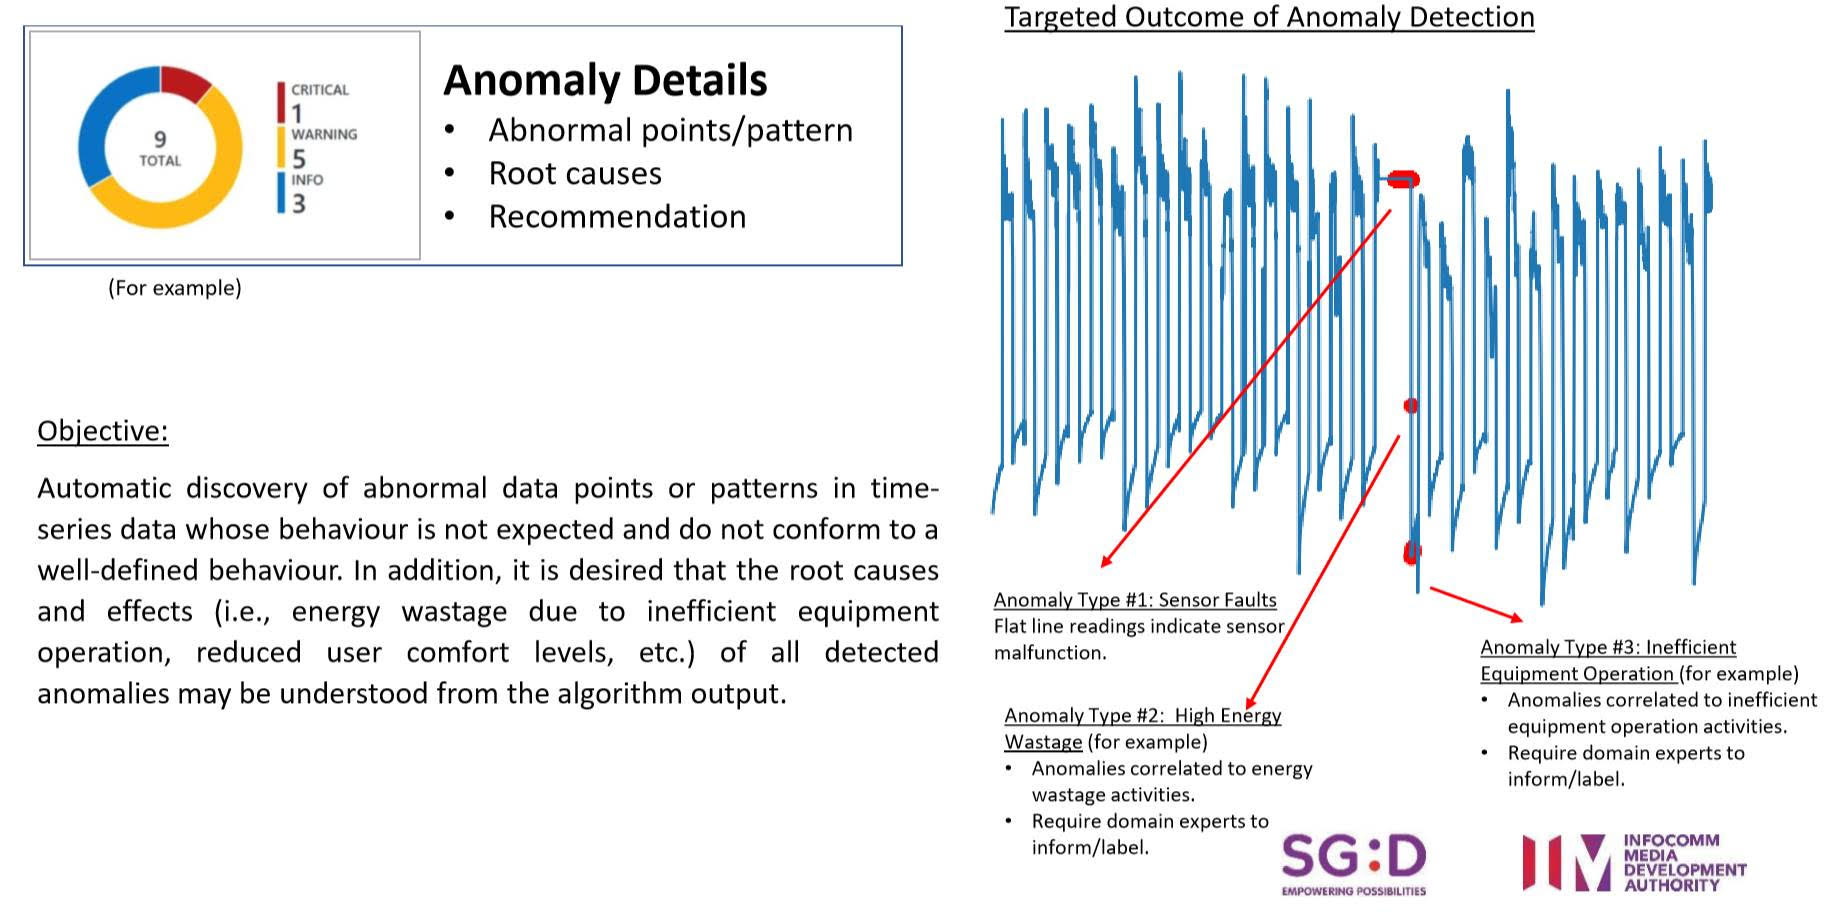

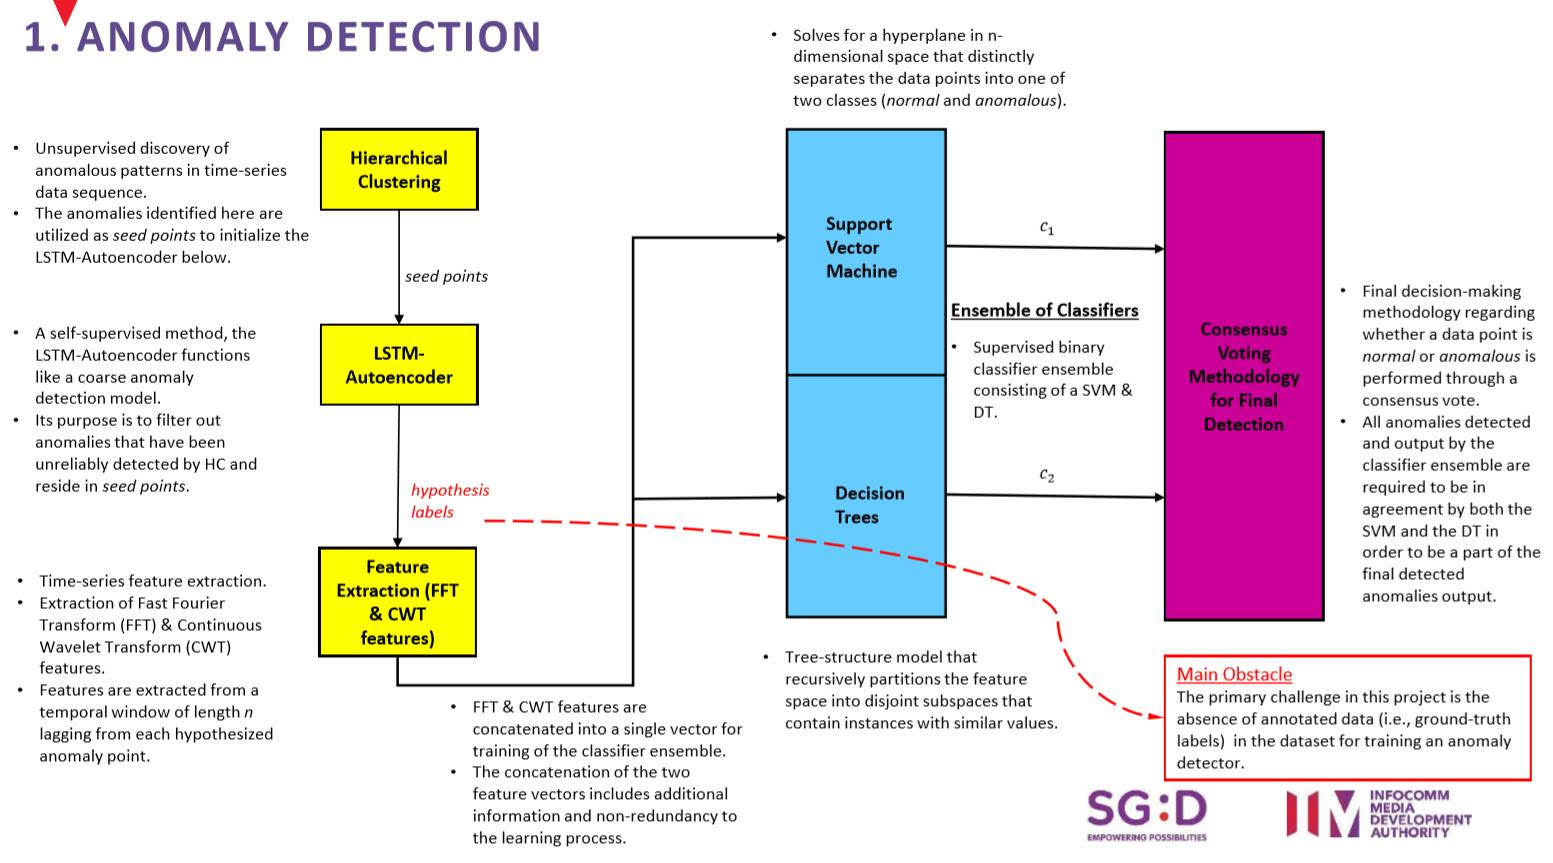

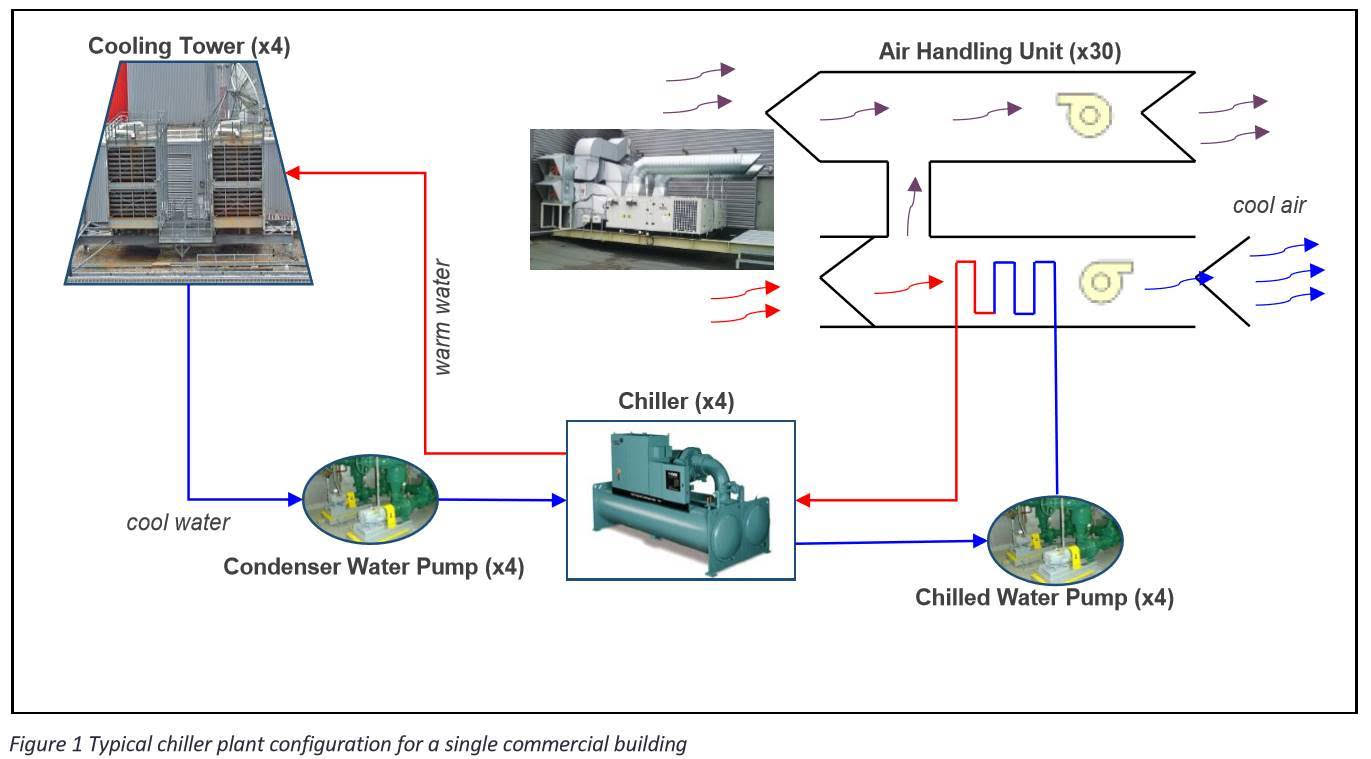
## Columns meaning:
 - CWRT: Condenser Water Return Temperature
 - HLI Entering CHW Temp: High Level Interface Entering (Return) Chilled Water Temperature

__*Anomaly Types*__ <br>
1. sensor fault
2. high energy wastage anomaly
3. inefficient equipment operation anomaly

In [2]:
def chopts(df_, cols, nts=int(24*60/5), overlapts=int(24*60/5)-1):
    # assume df_.index has no missing timestamps
    df = df_.copy()
    allts = list(df.index)
    allts.sort()
    ind = [j*(nts-overlapts) for j in range(int(len(allts)/(nts-overlapts)))]
    tsgrp = []
    for i in ind:
        tmp = allts[i: i+nts]
        if len(tmp) == nts:
            tsgrp.append(tmp)
    
    result = pd.DataFrame({'data': [df.loc[df.index.isin(tsgrp[i]), cols] for i in range(len(tsgrp))], 
                           'from': [tsgrp[i][0] for i in range(len(tsgrp))], 
                           'to': [tsgrp[i][-1] for i in range(len(tsgrp))]})
    return result



## Read Data

In [3]:
maincols = ['CWRT_syth', 'HLI Entering CHW Temp']
derivecol = ['(CWRT_syth)-(HLI Entering CHW Temp)']
timecols=['weekday', 'hourminute']

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

#### data_2_clean

In [4]:
data_2_clean = pd.read_csv(rootPath+'data_2_clean.csv', 
                          index_col='Unnamed: 0', date_parser=dateparse)
# create additional features
data_2_clean['(CWRT_syth)-(HLI Entering CHW Temp)'] = \
    data_2_clean['CWRT_syth']-data_2_clean['HLI Entering CHW Temp']


print(data_2_clean.shape)
print(data_2_clean.dtypes)
print(min(data_2_clean.index), max(data_2_clean.index))
display(data_2_clean.head())


(17719, 5)
CWRT_syth                              float64
HLI Entering CHW Temp                  float64
weekday                                  int64
hourminute                               int64
(CWRT_syth)-(HLI Entering CHW Temp)    float64
dtype: object
2019-01-13 00:00:00 2019-03-15 12:30:00


,CWRT_syth,HLI Entering CHW Temp,weekday,hourminute,(CWRT_syth)-(HLI Entering CHW Temp)
2019-01-13 00:00:00,30.490000,11.700000,7,0,18.790000
2019-01-13 00:05:00,30.506000,11.125000,7,5,19.381000
2019-01-13 00:10:00,30.530001,10.600000,7,10,19.930000
2019-01-13 00:15:00,30.546000,10.633334,7,15,19.912667
2019-01-13 00:20:00,30.590000,10.666667,7,20,19.923333


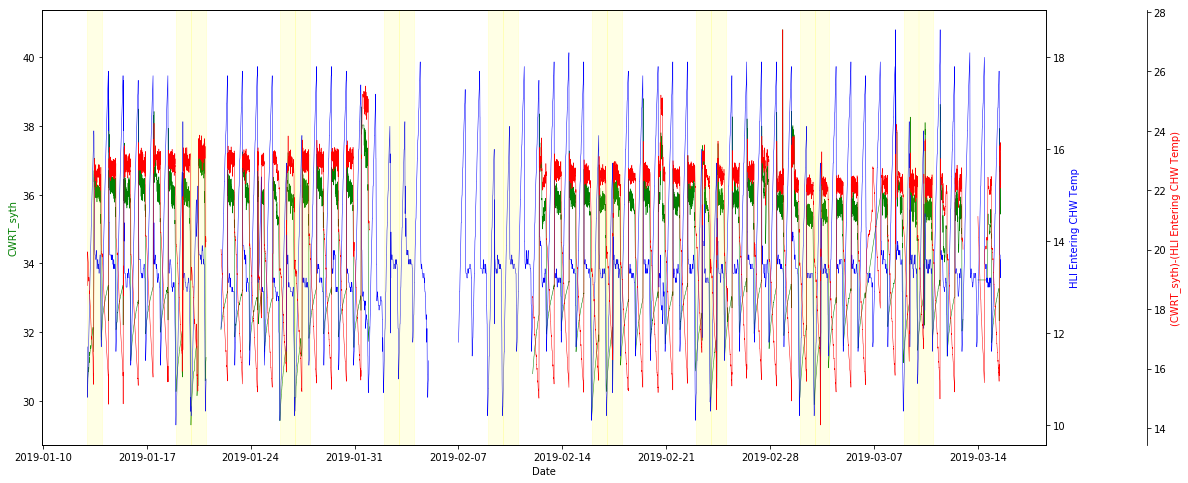

In [5]:
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.1))

for c, ax_, clr in zip(maincols+derivecol, [ax1, ax2, ax3], ['g', 'b', 'r']):
    ax_.plot_date(data_2_clean.index, data_2_clean[c], c=clr[0], 
                  markersize=0.5, marker='', linewidth=0.5, linestyle='-')
    ax_.set_ylabel(c, color=clr)
    ax_.set_xlabel('Date')

tmp = data_2_clean.index.to_frame()
tmp['wkday'] = data_2_clean.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
plt.show()


#### data_2

In [6]:
data_2 = pd.read_csv(rootPath+'data_2.csv', index_col='Unnamed: 0', date_parser=dateparse)
# create additional features
data_2['(CWRT_syth)-(HLI Entering CHW Temp)'] = data_2['CWRT_syth']-data_2['HLI Entering CHW Temp']

print(data_2.shape)
print(data_2.dtypes)
print(min(data_2.index), max(data_2.index))
display(data_2.head())


(17719, 13)
Date                                          object
Time                                          object
CWRT_syth                                    float64
HLI Entering CHW Temp                        float64
LABEL_(CWRT_syth)_(wrong_gap)                   bool
LABEL_(HLI Entering CHW Temp)_(wrong_gap)       bool
weekday                                        int64
hourminute                                     int64
Score_(CWRT_syth)_distanced                  float64
Score_(HLI Entering CHW Temp)_distanced      float64
Score_(CWRT_syth)_cluster                    float64
Score_(HLI Entering CHW Temp)_cluster        float64
(CWRT_syth)-(HLI Entering CHW Temp)          float64
dtype: object
2019-01-13 00:00:00 2019-03-15 12:30:00


,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),weekday,hourminute,Score_(CWRT_syth)_distanced,Score_(HLI Entering CHW Temp)_distanced,Score_(CWRT_syth)_cluster,Score_(HLI Entering CHW Temp)_cluster,(CWRT_syth)-(HLI Entering CHW Temp)
2019-01-13 00:00:00,2019-01-13,0000h,31.090000,NaN,False,False,7,0,0.0,NaN,27.467759,2.62796,NaN
2019-01-13 00:05:00,2019-01-13,0005h,31.106000,NaN,False,False,7,5,0.0,NaN,27.467759,2.62796,NaN
2019-01-13 00:10:00,2019-01-13,0010h,31.129999,10.6,False,False,7,10,0.0,0.0,27.467759,2.62796,20.529999
2019-01-13 00:15:00,2019-01-13,0015h,31.146000,NaN,False,False,7,15,0.0,NaN,27.467759,2.62796,NaN
2019-01-13 00:20:00,2019-01-13,0020h,31.170000,NaN,False,False,7,20,0.0,NaN,27.467759,2.62796,NaN


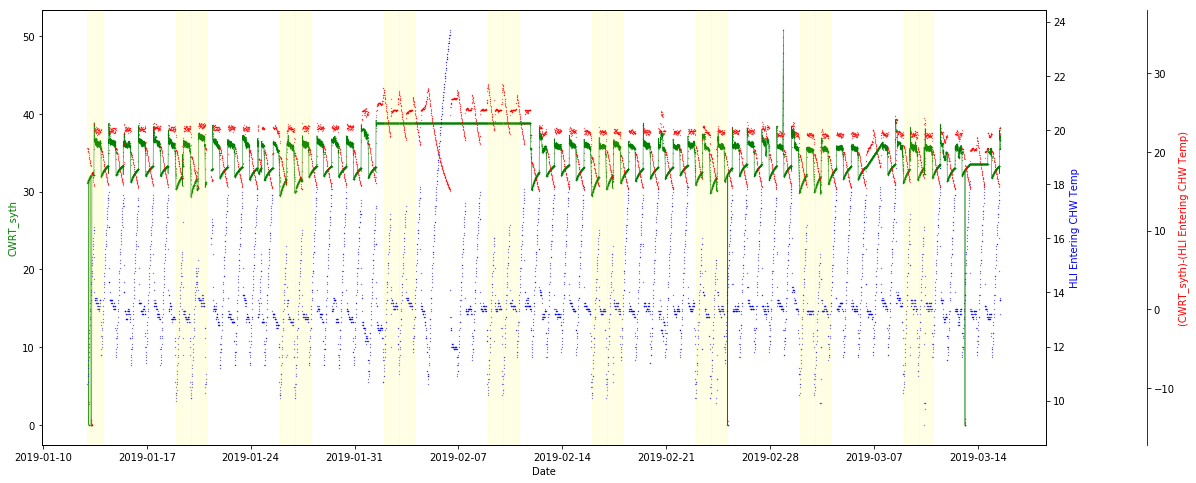

In [7]:
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.1))

for c, ax_, clr in zip(maincols+derivecol, [ax1, ax2, ax3], ['g', 'b', 'r']):
    ax_.plot_date(data_2.index, data_2[c], c=clr[0], 
                  markersize=0.5, marker='.', linewidth=0.5, linestyle='-')
    ax_.set_ylabel(c, color=clr)
    ax_.set_xlabel('Date')

tmp = data_2.index.to_frame()
tmp['wkday'] = data_2.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
plt.show()


#### data_2_impute

In [8]:
data_2_impute = pd.read_csv(rootPath+'data_2_impute.csv', index_col='Unnamed: 0', date_parser=dateparse)
# create additional features
data_2_impute['(CWRT_syth)-(HLI Entering CHW Temp)'] = data_2_impute['CWRT_syth']-data_2_impute['HLI Entering CHW Temp']

print(data_2_impute.shape)
print(data_2_impute.dtypes)
print(min(data_2_impute.index), max(data_2_impute.index))
display(data_2_impute.head())


(17789, 17)
Date                                          object
Time                                          object
CWRT_syth                                    float64
HLI Entering CHW Temp                        float64
LABEL_(CWRT_syth)_(wrong_gap)                 object
LABEL_(HLI Entering CHW Temp)_(wrong_gap)     object
weekday                                        int64
hourminute                                     int64
Score_(CWRT_syth)_distanced                  float64
Score_(HLI Entering CHW Temp)_distanced      float64
Score_(CWRT_syth)_cluster                    float64
Score_(HLI Entering CHW Temp)_cluster        float64
CWRT_syth_leave_empty                           bool
CWRT_syth_fill_median                           bool
HLI Entering CHW Temp_leave_empty               bool
HLI Entering CHW Temp_fill_median               bool
(CWRT_syth)-(HLI Entering CHW Temp)          float64
dtype: object
2019-01-12 21:05:00 2019-03-15 15:25:00


,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),weekday,hourminute,Score_(CWRT_syth)_distanced,Score_(HLI Entering CHW Temp)_distanced,Score_(CWRT_syth)_cluster,Score_(HLI Entering CHW Temp)_cluster,CWRT_syth_leave_empty,CWRT_syth_fill_median,HLI Entering CHW Temp_leave_empty,HLI Entering CHW Temp_fill_median,(CWRT_syth)-(HLI Entering CHW Temp)
2019-01-12 21:05:00,NaN,NaN,35.709999,13.300000,NaN,NaN,6,1265,NaN,NaN,NaN,NaN,False,True,False,True,22.409999
2019-01-12 21:10:00,NaN,NaN,35.641001,13.200000,NaN,NaN,6,1270,NaN,NaN,NaN,NaN,False,True,False,True,22.441001
2019-01-12 21:15:00,NaN,NaN,35.536000,12.983333,NaN,NaN,6,1275,NaN,NaN,NaN,NaN,False,True,False,True,22.552667
2019-01-12 21:20:00,NaN,NaN,35.425000,12.766667,NaN,NaN,6,1280,NaN,NaN,NaN,NaN,False,True,False,True,22.658333
2019-01-12 21:25:00,NaN,NaN,35.328000,12.550000,NaN,NaN,6,1285,NaN,NaN,NaN,NaN,False,True,False,True,22.778000


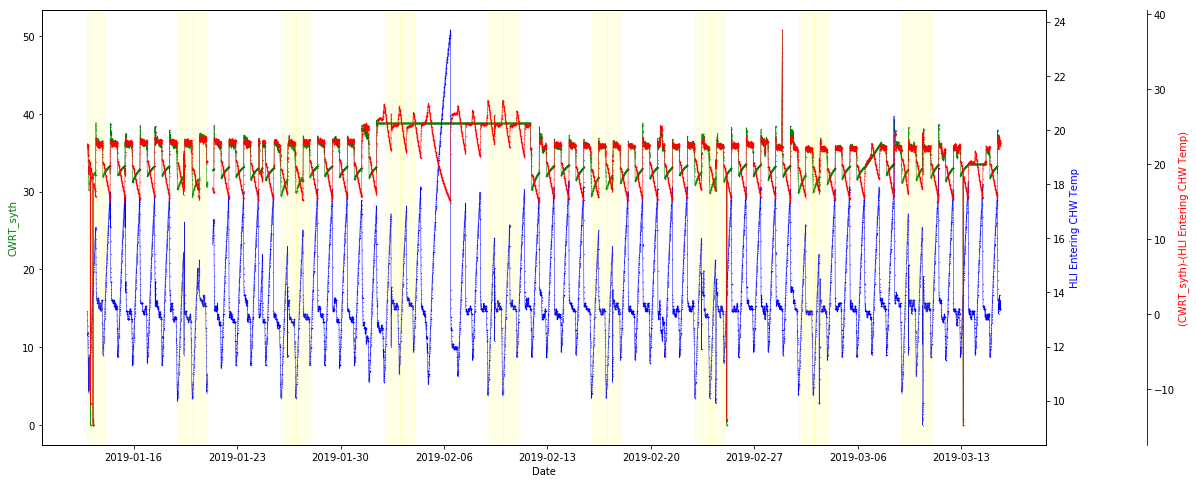

In [9]:
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.1))

for c, ax_, clr in zip(maincols+derivecol, [ax1, ax2, ax3], ['g', 'b', 'r']):
    ax_.plot_date(data_2_impute.index, data_2_impute[c], c=clr[0], 
                  markersize=0.5, marker='.', linewidth=0.5, linestyle='-')
    ax_.set_ylabel(c, color=clr)
    ax_.set_xlabel('Date')

tmp = data_2_impute.index.to_frame()
tmp['wkday'] = data_2_impute.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
plt.show()


## Prepare Data
#### For pre-cleaned imputed data

In [10]:
#------------------ min max scaling--------------------------
data_2_clean_scale = data_2_clean.copy()
scaler = MinMaxScaler()
scaler.fit(data_2_clean_scale[derivecol+maincols+timecols])
data_2_clean_scale[derivecol+maincols+timecols] = scaler.transform(
    data_2_clean_scale[derivecol+maincols+timecols])

print(data_2_clean_scale.shape)
display(data_2_clean_scale.head())

(17719, 5)


,CWRT_syth,HLI Entering CHW Temp,weekday,hourminute,(CWRT_syth)-(HLI Entering CHW Temp)
2019-01-13 00:00:00,0.103598,0.197674,1.0,0.000000,0.352590
2019-01-13 00:05:00,0.104989,0.130814,1.0,0.003484,0.397009
2019-01-13 00:10:00,0.107075,0.069767,1.0,0.006969,0.438270
2019-01-13 00:15:00,0.108465,0.073643,1.0,0.010453,0.436968
2019-01-13 00:20:00,0.112289,0.077519,1.0,0.013937,0.437769


In [11]:
#------------ sampling from sequence --------------------
number_ts = int(3*60/5) #int(6*60/5)

data_2_clean_scale_chop = chopts(
    data_2_clean_scale, derivecol+maincols+timecols, nts=number_ts, overlapts=number_ts-1)

data_2_clean_scale_chop['shape'] = data_2_clean_scale_chop['data'].apply(lambda x: x.shape)

for col in maincols+derivecol:
    data_2_clean_scale_chop[col+'_missing'] = data_2_clean_scale_chop[
        'data'].apply(lambda x: len(x[x[col].isna()]) / len(x))

print(min(data_2_clean_scale_chop['from']), max(data_2_clean_scale_chop['from']))
print(min(data_2_clean_scale_chop['to']), max(data_2_clean_scale_chop['to']))
print(data_2_clean_scale_chop.shape)
display(data_2_clean_scale_chop.head())
display(data_2_clean_scale_chop.describe())

2019-01-13 00:00:00 2019-03-15 09:35:00
2019-01-13 02:55:00 2019-03-15 12:30:00
(17684, 7)


,data,from,to,shape,CWRT_syth_missing,HLI Entering CHW Temp_missing,(CWRT_syth)-(HLI Entering CHW Temp)_missing
0,(CWRT_syth)-(HLI Entering...,2019-01-13 00:00:00,2019-01-13 02:55:00,"(36, 5)",0.0,0.0,0.0
1,(CWRT_syth)-(HLI Entering...,2019-01-13 00:05:00,2019-01-13 03:00:00,"(36, 5)",0.0,0.0,0.0
2,(CWRT_syth)-(HLI Entering...,2019-01-13 00:10:00,2019-01-13 03:05:00,"(36, 5)",0.0,0.0,0.0
3,(CWRT_syth)-(HLI Entering...,2019-01-13 00:15:00,2019-01-13 03:10:00,"(36, 5)",0.0,0.0,0.0
4,(CWRT_syth)-(HLI Entering...,2019-01-13 00:20:00,2019-01-13 03:15:00,"(36, 5)",0.0,0.0,0.0


,CWRT_syth_missing,HLI Entering CHW Temp_missing,(CWRT_syth)-(HLI Entering CHW Temp)_missing
count,17684.000000,17684.000000,17684.000000
mean,0.211717,0.050045,0.212791
std,0.406039,0.213562,0.406088
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


#### For None pre-cleaned but imputed data

In [12]:
#------------------ min max scaling--------------------------
data_2_impute_scale = data_2_impute.copy()
scaler = MinMaxScaler()
scaler.fit(data_2_impute_scale[derivecol+maincols+timecols])
data_2_impute_scale[derivecol+maincols+timecols] = scaler.transform(
    data_2_impute_scale[derivecol+maincols+timecols])

print(data_2_impute_scale.shape)
display(data_2_impute_scale.head())


(17789, 17)


,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),weekday,hourminute,Score_(CWRT_syth)_distanced,Score_(HLI Entering CHW Temp)_distanced,Score_(CWRT_syth)_cluster,Score_(HLI Entering CHW Temp)_cluster,CWRT_syth_leave_empty,CWRT_syth_fill_median,HLI Entering CHW Temp_leave_empty,HLI Entering CHW Temp_fill_median,(CWRT_syth)-(HLI Entering CHW Temp)
2019-01-12 21:05:00,NaN,NaN,0.702897,0.287671,NaN,NaN,0.833333,0.881533,NaN,NaN,NaN,NaN,False,True,False,True,0.704940
2019-01-12 21:10:00,NaN,NaN,0.701539,0.280822,NaN,NaN,0.833333,0.885017,NaN,NaN,NaN,NaN,False,True,False,True,0.705528
2019-01-12 21:15:00,NaN,NaN,0.699472,0.265982,NaN,NaN,0.833333,0.888502,NaN,NaN,NaN,NaN,False,True,False,True,0.707645
2019-01-12 21:20:00,NaN,NaN,0.697288,0.251142,NaN,NaN,0.833333,0.891986,NaN,NaN,NaN,NaN,False,True,False,True,0.709649
2019-01-12 21:25:00,NaN,NaN,0.695378,0.236301,NaN,NaN,0.833333,0.895470,NaN,NaN,NaN,NaN,False,True,False,True,0.711918


In [13]:
#------------ sampling from sequence --------------------
number_ts = int(3*60/5) #int(6*60/5)

data_2_impute_scale_chop = chopts(
    data_2_impute_scale, derivecol+maincols+timecols, nts=number_ts, overlapts=number_ts-1)

data_2_impute_scale_chop['shape'] = data_2_impute_scale_chop['data'].apply(lambda x: x.shape)

for col in maincols+derivecol:
    data_2_impute_scale_chop[col+'_missing'] = data_2_impute_scale_chop[
        'data'].apply(lambda x: len(x[x[col].isna()]) / len(x))

print(min(data_2_impute_scale_chop['from']), max(data_2_impute_scale_chop['from']))
print(min(data_2_impute_scale_chop['to']), max(data_2_impute_scale_chop['to']))
print(data_2_impute_scale_chop.shape)
display(data_2_impute_scale_chop.head())
display(data_2_impute_scale_chop.describe())

2019-01-12 21:05:00 2019-03-15 12:30:00
2019-01-13 00:00:00 2019-03-15 15:25:00
(17754, 7)


,data,from,to,shape,CWRT_syth_missing,HLI Entering CHW Temp_missing,(CWRT_syth)-(HLI Entering CHW Temp)_missing
0,(CWRT_syth)-(HLI Entering...,2019-01-12 21:05:00,2019-01-13 00:00:00,"(36, 5)",0.0,0.0,0.0
1,(CWRT_syth)-(HLI Entering...,2019-01-12 21:10:00,2019-01-13 00:05:00,"(36, 5)",0.0,0.0,0.0
2,(CWRT_syth)-(HLI Entering...,2019-01-12 21:15:00,2019-01-13 00:10:00,"(36, 5)",0.0,0.0,0.0
3,(CWRT_syth)-(HLI Entering...,2019-01-12 21:20:00,2019-01-13 00:15:00,"(36, 5)",0.0,0.0,0.0
4,(CWRT_syth)-(HLI Entering...,2019-01-12 21:25:00,2019-01-13 00:20:00,"(36, 5)",0.0,0.0,0.0


,CWRT_syth_missing,HLI Entering CHW Temp_missing,(CWRT_syth)-(HLI Entering CHW Temp)_missing
count,17754.000000,17754.000000,17754.000000
mean,0.005464,0.005520,0.005520
std,0.068983,0.069385,0.069385
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


## Autoencoder

In [14]:
def getpredict(model, dataarray):
    tmp = dataarray.reshape(1, dataarray.shape[0], dataarray.shape[1])
    return model.predict(tmp)

def calpredtruediff(predarray, truearray, colsind):
    true = truearray[:, colsind]
    pred = predarray.reshape(predarray.shape[1])
    return (true-pred)

def calwindowperformance(dftrue_, dfpred, col, colnames=maincols):
    dftrue = dftrue_.copy()
    dfpred.columns = colnames
    absdiff = abs(dftrue_[col] - dfpred[col])
    return {'mae': absdiff.mean(), 'mse': (absdiff**2).mean(), 'rmse': (absdiff**2).mean()**0.5}
    
def normalize_scores(pds_):
    pds = pds_.copy()
    pds_max = pds.max()
    pds_min = pds.min()
    return 100*(pds - pds_min).div(pds_max - pds_min)    

### <font color=grey>Autoencoder:</font> <font color=green>CWRT_syth</font>

In [15]:
col = 'CWRT_syth'

In [16]:
chop_nomissing = data_2_clean_scale_chop[data_2_clean_scale_chop[col+'_missing']==0].copy()
print(chop_nomissing.shape, chop_nomissing.shape)
display(chop_nomissing.head())

cond = chop_nomissing['shape']==chop_nomissing['shape'].value_counts(ascending=False).index[0]

data_x = np.stack(list(chop_nomissing.loc[cond, 'data'].apply(lambda x: x[[col]+timecols].values)))
print(data_x.shape)
display(data_x)

# check for nan
print(data_x[np.isnan(data_x)])

(13835, 7) (13835, 7)


,data,from,to,shape,CWRT_syth_missing,HLI Entering CHW Temp_missing,(CWRT_syth)-(HLI Entering CHW Temp)_missing
0,(CWRT_syth)-(HLI Entering...,2019-01-13 00:00:00,2019-01-13 02:55:00,"(36, 5)",0.0,0.0,0.0
1,(CWRT_syth)-(HLI Entering...,2019-01-13 00:05:00,2019-01-13 03:00:00,"(36, 5)",0.0,0.0,0.0
2,(CWRT_syth)-(HLI Entering...,2019-01-13 00:10:00,2019-01-13 03:05:00,"(36, 5)",0.0,0.0,0.0
3,(CWRT_syth)-(HLI Entering...,2019-01-13 00:15:00,2019-01-13 03:10:00,"(36, 5)",0.0,0.0,0.0
4,(CWRT_syth)-(HLI Entering...,2019-01-13 00:20:00,2019-01-13 03:15:00,"(36, 5)",0.0,0.0,0.0


(13835, 36, 3)


array([[[0.10359803, 1.        , 0.        ],
        [0.10498864, 1.        , 0.00348432],
        [0.10707456, 1.        , 0.00696864],
        ...,
        [0.15922113, 1.        , 0.11498258],
        [0.16061174, 1.        , 0.1184669 ],
        [0.16269765, 1.        , 0.12195122]],

       [[0.10498864, 1.        , 0.00348432],
        [0.10707456, 1.        , 0.00696864],
        [0.1084651 , 1.        , 0.01045296],
        ...,
        [0.16061174, 1.        , 0.1184669 ],
        [0.16269765, 1.        , 0.12195122],
        [0.16443585, 1.        , 0.12543554]],

       [[0.10707456, 1.        , 0.00696864],
        [0.1084651 , 1.        , 0.01045296],
        [0.11228918, 1.        , 0.01393728],
        ...,
        [0.16269765, 1.        , 0.12195122],
        [0.16443585, 1.        , 0.12543554],
        [0.16704315, 1.        , 0.12891986]],

       ...,

       [[0.34173462, 0.66666667, 0.39372822],
        [0.34521114, 0.66666667, 0.39721254],
        [0.34521114, 0

[]


In [17]:
#from keras.optimizers import SGD, Adam
visible = Input(shape=(data_x.shape[1], data_x.shape[2]))
encoder = LSTM(300, activation='relu')(visible)
# define reconstruct decoder
decoder1 = RepeatVector(data_x.shape[1])(encoder)
decoder1 = LSTM(300, activation='relu', return_sequences=True)(decoder1)
decoder1 = TimeDistributed(Dense(1))(decoder1)

model_0 = Model(inputs=visible, outputs=decoder1)
#sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=100)
adam = Adam(lr=0.001)
model_0.compile(loss='mean_squared_error', optimizer=adam)
model_0.summary()

epc = 15
model_0.fit(data_x, data_x[:, :, [0]], epochs=epc, verbose=1)
model_0.save('autoencoder_0.h5')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 36, 3)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               364800    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 36, 300)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 36, 300)           721200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 36, 1)             301       
Total params: 1,086,301
Trainable params: 1,086,301
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
1

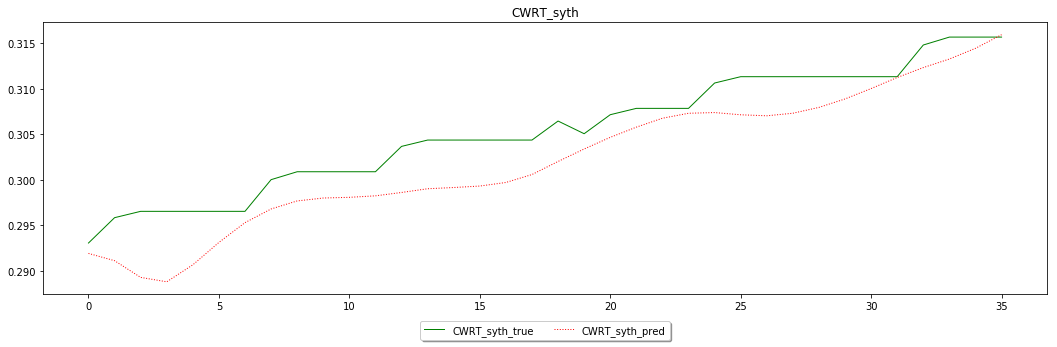

In [18]:
# --------------- check some examples --------------------
darray_0 = data_x[4930]  # 100, 1500, 4930
pred_0 = getpredict(model_0, darray_0)

# plot
fig, ax1 = plt.subplots(figsize=(18, 5))

ax1.plot(darray_0[:, 0], c='green', linewidth=1, linestyle='-', label=col+'_true')
ax1.plot(pred_0[0, :, 0], c='red', linewidth=1, linestyle=':', label=col+'_pred')
#ax1.set_ylim(0, 1)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
plt.title(col)
plt.show()

In [17]:
#model_0 = load_model('autoencoder_0.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [18]:
# ------------ predict all ------------
chop_nomissing['pred_('+col+')'] = chop_nomissing['data'].apply(
    lambda x: pd.DataFrame(getpredict(model_0, x[[col]+timecols].values)[0, :, :], 
                           columns=[col], index = x.index))
print(chop_nomissing.shape)
display(chop_nomissing.head())

allpredictions = pd.concat(chop_nomissing['pred_('+col+')'].values, axis=1)
allpredictions['mean'] = allpredictions.mean(axis=1)
allpredictions['median'] = allpredictions.median(axis=1)
allpredictions['std'] = allpredictions.std(axis=1)
allpredictions['min'] = allpredictions.min(axis=1)
allpredictions['max'] = allpredictions.max(axis=1)
allpredictions['numpreds'] = allpredictions.count(axis=1)
allpredictions = allpredictions[['mean', 'median', 'min', 'max', 'std', 'numpreds']]

print(allpredictions.shape)
display(allpredictions.head())

(13835, 8)


,data,from,to,shape,CWRT_syth_missing,HLI Entering CHW Temp_missing,(CWRT_syth)-(HLI Entering CHW Temp)_missing,pred_(CWRT_syth)
0,(CWRT_syth)-(HLI Entering...,2019-01-13 00:00:00,2019-01-13 02:55:00,"(36, 5)",0.0,0.0,0.0,CWRT_syth 2019-01-13 00:0...
1,(CWRT_syth)-(HLI Entering...,2019-01-13 00:05:00,2019-01-13 03:00:00,"(36, 5)",0.0,0.0,0.0,CWRT_syth 2019-01-13 00:0...
2,(CWRT_syth)-(HLI Entering...,2019-01-13 00:10:00,2019-01-13 03:05:00,"(36, 5)",0.0,0.0,0.0,CWRT_syth 2019-01-13 00:1...
3,(CWRT_syth)-(HLI Entering...,2019-01-13 00:15:00,2019-01-13 03:10:00,"(36, 5)",0.0,0.0,0.0,CWRT_syth 2019-01-13 00:1...
4,(CWRT_syth)-(HLI Entering...,2019-01-13 00:20:00,2019-01-13 03:15:00,"(36, 5)",0.0,0.0,0.0,CWRT_syth 2019-01-13 00:2...


(13975, 6)


,mean,median,min,max,std,numpreds
2019-01-13 00:00:00,0.100393,0.100393,0.000000,0.100393,0.000000,6
2019-01-13 00:05:00,0.101073,0.101073,0.000750,0.101991,0.000750,7
2019-01-13 00:10:00,0.101601,0.101893,0.001625,0.103542,0.001625,8
2019-01-13 00:15:00,0.102311,0.102311,0.002182,0.104990,0.002182,9
2019-01-13 00:20:00,0.103374,0.103412,0.002331,0.106427,0.002331,10


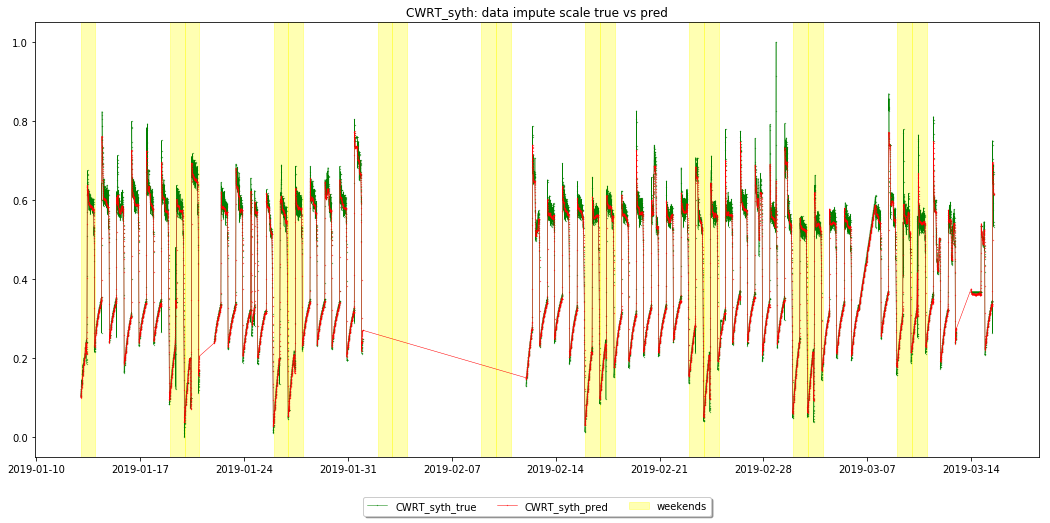

In [19]:
# plot: compare true with pred
plt.subplots(figsize=(18, 8))
plt.plot_date(data_2_clean_scale.index, data_2_clean_scale[col], 
              c='green',  markersize=0.5,  marker='.', linewidth=0.5, linestyle='-', label=col+'_true')
plt.plot_date(allpredictions.index, allpredictions['mean'], 
              c='red',  markersize=0.5,  marker='.', linewidth=0.5, linestyle='-', label=col+'_pred')

tmp = data_2_clean_scale.index.to_frame()
tmp['wkday'] = data_2_clean_scale.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
    i += 1

plt.title(col+': data impute scale true vs pred')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
plt.show()

min(CWRT_syth-meanpred)=-0.21105255123895184
max(CWRT_syth-meanpred)=0.35676044225692793
mean(CWRT_syth-meanpred)=0.004094782327265102
std(CWRT_syth-meanpred)=0.018396292494117627
(17719, 9)


,CWRT_syth,CWRT_syth_mean,CWRT_syth_median,CWRT_syth_min,CWRT_syth_max,CWRT_syth_std,CWRT_syth_numpreds,CWRT_syth-meanpred,abs(CWRT_syth-meanpred)
2019-01-13 00:00:00,0.103598,0.100393,0.100393,0.000000,0.100393,0.000000,6.0,0.003205,0.003205
2019-01-13 00:05:00,0.104989,0.101073,0.101073,0.000750,0.101991,0.000750,7.0,0.003916,0.003916
2019-01-13 00:10:00,0.107075,0.101601,0.101893,0.001625,0.103542,0.001625,8.0,0.005474,0.005474
2019-01-13 00:15:00,0.108465,0.102311,0.102311,0.002182,0.104990,0.002182,9.0,0.006154,0.006154
2019-01-13 00:20:00,0.112289,0.103374,0.103412,0.002331,0.106427,0.002331,10.0,0.008915,0.008915


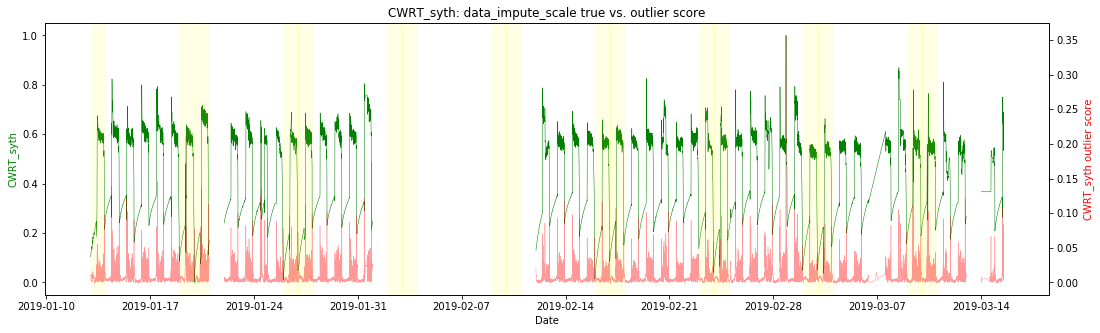

In [20]:
scaledscorediff = pd.concat([data_2_clean_scale[col], 
                             allpredictions.rename(columns = {k: col+'_'+k for k in list(allpredictions)})], 
                            axis=1)
scaledscorediff[col+'-meanpred'] = scaledscorediff[col] - scaledscorediff[col+'_mean']
scaledscorediff['abs('+col+'-meanpred)'] = abs(scaledscorediff[col+'-meanpred'])
print('min({})={}'.format(col+'-meanpred', scaledscorediff[col+'-meanpred'].min()))
print('max({})={}'.format(col+'-meanpred', scaledscorediff[col+'-meanpred'].max()))
print('mean({})={}'.format(col+'-meanpred', scaledscorediff[col+'-meanpred'].mean()))
print('std({})={}'.format(col+'-meanpred', scaledscorediff[col+'-meanpred'].std()))
              
print(scaledscorediff.shape)
display(scaledscorediff.head())

# ------------ outlier score plot ------------------
fig, ax1 = plt.subplots(figsize=(18, 5))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data_2_clean_scale.index, data_2_clean_scale[col], 
              c='green',  markersize=0.5,  marker='', linewidth=0.5, linestyle='-')
ax1.set_ylabel(col, color='green')
ax1.set_xlabel('Date')

ax2.plot_date(scaledscorediff.index, scaledscorediff['abs('+col+'-meanpred)'], 
              c='red',  markersize=0.5,  marker='', linewidth=0.5, linestyle='-', alpha=0.4)
ax2.set_ylabel(col+' outlier score', color='red')
ax2.set_xlabel('Date')

tmp = data_2_clean_scale.index.to_frame()
tmp['wkday'] = data_2_clean_scale.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1

plt.title(col+': data_impute_scale true vs. outlier score')
plt.show()

#### Prediction on data_2_impute_scale_chop

In [21]:
data_2_impute_scale_chop['pred_'+col] = data_2_impute_scale_chop['data'].apply(
    lambda x: pd.DataFrame(getpredict(model_0, x[[col]+timecols].values)[0, :, :], 
                           columns=[col], index = x.index))

In [22]:
# allpredictions_1: get score statistics (mean, median, std, min, max) of all the predictions of each timestamp
allpredictions_1 = pd.concat(data_2_impute_scale_chop['pred_'+col].values, axis=1)
allpredictions_1['mean'] = allpredictions_1.mean(axis=1)
allpredictions_1['median'] = allpredictions_1.median(axis=1)
allpredictions_1['std'] = allpredictions_1.std(axis=1)
allpredictions_1['min'] = allpredictions_1.min(axis=1)
allpredictions_1['max'] = allpredictions_1.max(axis=1)
allpredictions_1['numpreds'] = allpredictions_1.count(axis=1)
cols_ = ['mean', 'median', 'min', 'max', 'std', 'numpreds']
allpredictions_1 = allpredictions_1[cols_]
allpredictions_1.columns = cols_

print(allpredictions_1.shape)
display(allpredictions_1.head())


# merge to data_2
tmp = pd.concat([data_2_impute_scale, allpredictions_1[['mean', 'median']].rename(
        columns={'mean': 'Pred_'+col+'_timestamp_mean', 
                 'median': 'Pred_'+col+'_timestamp_median'})], axis=1)
tmp['Score_('+col+')_timstamp_normalized(mean)'] = normalize_scores(
    abs(tmp['Pred_'+col+'_timestamp_mean']-tmp[col]))
tmp['Score_('+col+')_timstamp_normalized(median)'] = normalize_scores(
    abs(tmp['Pred_'+col+'_timestamp_median']-tmp[col]))

data_2 = data_2.merge(tmp[
    ['Score_('+col+')_timstamp_normalized(mean)', 'Score_('+col+')_timstamp_normalized(median)']], 
                      how='left', left_on=data_2.index, 
                      right_on=tmp.index).set_index('key_0')
data_2.index.name = 'timestamp'

data_2.loc[data_2[col].isna(), 'Score_('+col+')_timstamp_normalized(mean)'] = np.nan
data_2.loc[data_2[col].isna(), 'Score_('+col+')_timstamp_normalized(median)'] = np.nan

display(data_2.head())
display(data_2.describe())

/Users/phuw273g/.conda/envs/untitled/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


(17789, 6)


,mean,median,min,max,std,numpreds
2019-01-12 21:05:00,0.653987,0.653987,0.000000,0.653987,0.000000,6
2019-01-12 21:10:00,0.642417,0.642417,0.009899,0.654541,0.009899,7
2019-01-12 21:15:00,0.637502,0.639343,0.016766,0.659126,0.016766,8
2019-01-12 21:20:00,0.635388,0.635388,0.018428,0.658490,0.018428,9
2019-01-12 21:25:00,0.635461,0.637481,0.018006,0.659588,0.018006,10


,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),weekday,hourminute,Score_(CWRT_syth)_distanced,Score_(HLI Entering CHW Temp)_distanced,Score_(CWRT_syth)_cluster,Score_(HLI Entering CHW Temp)_cluster,(CWRT_syth)-(HLI Entering CHW Temp),Score_(CWRT_syth)_timstamp_normalized(mean),Score_(CWRT_syth)_timstamp_normalized(median)
timestamp,,,,,,,,,,,,,,,
2019-01-13 00:00:00,2019-01-13,0000h,31.090000,NaN,False,False,7,0,0.0,NaN,27.467759,2.62796,NaN,3.543680,6.561008
2019-01-13 00:05:00,2019-01-13,0005h,31.106000,NaN,False,False,7,5,0.0,NaN,27.467759,2.62796,NaN,2.795790,6.304358
2019-01-13 00:10:00,2019-01-13,0010h,31.129999,10.6,False,False,7,10,0.0,0.0,27.467759,2.62796,20.529999,2.004219,6.087916
2019-01-13 00:15:00,2019-01-13,0015h,31.146000,NaN,False,False,7,15,0.0,NaN,27.467759,2.62796,NaN,1.135051,5.981746
2019-01-13 00:20:00,2019-01-13,0020h,31.170000,NaN,False,False,7,20,0.0,NaN,27.467759,2.62796,NaN,0.203464,5.923117


,CWRT_syth,HLI Entering CHW Temp,weekday,hourminute,Score_(CWRT_syth)_distanced,Score_(HLI Entering CHW Temp)_distanced,Score_(CWRT_syth)_cluster,Score_(HLI Entering CHW Temp)_cluster,(CWRT_syth)-(HLI Entering CHW Temp),Score_(CWRT_syth)_timstamp_normalized(mean),Score_(CWRT_syth)_timstamp_normalized(median)
count,17615.000000,5868.000000,17719.000000,17719.000000,17615.000000,5868.000000,17568.000000,17568.000000,5865.000000,17615.000000,17615.000000
mean,34.761378,13.929772,3.959761,714.581240,0.422026,1.481149,11.043301,5.973006,20.821234,3.988672,5.947572
std,3.042954,1.861147,2.005443,415.609241,5.160662,10.806613,19.247590,18.262006,3.491175,3.372484,4.460585
min,0.000000,9.100000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.700000,0.000000,0.000000
25%,32.669998,13.000000,2.000000,355.000000,0.000000,0.000000,0.750721,0.710433,18.259998,2.817709,4.161784
50%,35.330001,13.500000,4.000000,710.000000,0.000000,0.000000,1.364830,1.562910,21.925998,3.506175,5.195667
75%,36.368999,14.800000,6.000000,1075.000000,0.000000,0.000000,7.998246,3.013914,22.897999,4.389234,6.537169
max,50.804002,23.700001,7.000000,1435.000000,100.000000,100.000000,100.000000,100.000000,35.504001,100.000000,100.000000


In [24]:
# allpredictions_2: assign window score (mae, mse, rmse) to the last timestamp of the window
tmp = data_2_impute_scale_chop[['data', 'pred_'+col]].copy()
tmp['performance'] = tmp.apply(
    lambda row: calwindowperformance(row['data'], row['pred_'+col], col, [col]), axis=1)
tmp['timestamp'] = data_2_impute_scale_chop['pred_'+col].apply(
    lambda x: x.index[-1])
tmp.columns = ['data', 'pred_'+col, 'performance', 'timestamp']
allmtc = ['mae', 'rmse']
for mtc in allmtc:
    tmp[mtc] = tmp['performance'].apply(lambda x: x[mtc])
    tmp['normalized('+mtc+')'] = normalize_scores(tmp[mtc])

allpredictions_2 = tmp[['timestamp']+allmtc+['normalized('+mtc+')' for mtc in allmtc]].copy().set_index('timestamp')
print(allpredictions_2.shape)
display(allpredictions_2.head())

# merge to data_2
data_2 = data_2.merge(allpredictions_2[
    ['normalized(mae)', 'normalized(rmse)']].rename(
    columns={'normalized(mae)': 'Score_('+col+')_window_normalized(mae)',
             'normalized(rmse)': 'Score_('+col+')_window_normalized(rmse)'}), 
                      how='left', left_on=data_2.index, 
                      right_on=allpredictions_2.index).set_index('key_0')
data_2.index.name = 'timestamp'

data_2.loc[data_2[col].isna(), 'Score_('+col+')_window_normalized(mae)'] = np.nan
data_2.loc[data_2[col].isna(), 'Score_('+col+')_window_normalized(rmse)'] = np.nan

display(data_2.head())
display(data_2.describe())


(17754, 4)


,mae,rmse,normalized(mae),normalized(rmse)
timestamp,,,,
2019-01-13 00:00:00,0.025303,0.027849,0.742736,0.395876
2019-01-13 00:05:00,0.039959,0.041412,1.586232,0.790690
2019-01-13 00:10:00,0.049577,0.051933,2.139763,1.096965
2019-01-13 00:15:00,0.054821,0.058464,2.441556,1.287084
2019-01-13 00:20:00,0.056081,0.060731,2.514081,1.353066


,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),weekday,hourminute,Score_(CWRT_syth)_distanced,Score_(HLI Entering CHW Temp)_distanced,Score_(CWRT_syth)_cluster,Score_(HLI Entering CHW Temp)_cluster,(CWRT_syth)-(HLI Entering CHW Temp),Score_(CWRT_syth)_timstamp_normalized(mean),Score_(CWRT_syth)_timstamp_normalized(median),Score_(CWRT_syth)_window_normalized(mae),Score_(CWRT_syth)_window_normalized(rmse)
timestamp,,,,,,,,,,,,,,,,,
2019-01-13 00:00:00,2019-01-13,0000h,31.090000,NaN,False,False,7,0,0.0,NaN,27.467759,2.62796,NaN,3.543680,6.561008,0.742736,0.395876
2019-01-13 00:05:00,2019-01-13,0005h,31.106000,NaN,False,False,7,5,0.0,NaN,27.467759,2.62796,NaN,2.795790,6.304358,1.586232,0.790690
2019-01-13 00:10:00,2019-01-13,0010h,31.129999,10.6,False,False,7,10,0.0,0.0,27.467759,2.62796,20.529999,2.004219,6.087916,2.139763,1.096965
2019-01-13 00:15:00,2019-01-13,0015h,31.146000,NaN,False,False,7,15,0.0,NaN,27.467759,2.62796,NaN,1.135051,5.981746,2.441556,1.287084
2019-01-13 00:20:00,2019-01-13,0020h,31.170000,NaN,False,False,7,20,0.0,NaN,27.467759,2.62796,NaN,0.203464,5.923117,2.514081,1.353066


,CWRT_syth,HLI Entering CHW Temp,weekday,hourminute,Score_(CWRT_syth)_distanced,Score_(HLI Entering CHW Temp)_distanced,Score_(CWRT_syth)_cluster,Score_(HLI Entering CHW Temp)_cluster,(CWRT_syth)-(HLI Entering CHW Temp),Score_(CWRT_syth)_timstamp_normalized(mean),Score_(CWRT_syth)_timstamp_normalized(median),Score_(CWRT_syth)_window_normalized(mae),Score_(CWRT_syth)_window_normalized(rmse)
count,17615.000000,5868.000000,17719.000000,17719.000000,17615.000000,5868.000000,17568.000000,17568.000000,5865.000000,17615.000000,17615.000000,17581.000000,17581.000000
mean,34.761378,13.929772,3.959761,714.581240,0.422026,1.481149,11.043301,5.973006,20.821234,3.988672,5.947572,0.801522,0.417440
std,3.042954,1.861147,2.005443,415.609241,5.160662,10.806613,19.247590,18.262006,3.491175,3.372484,4.460585,1.849167,1.363385
min,0.000000,9.100000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.700000,0.000000,0.000000,0.000000,0.000000
25%,32.669998,13.000000,2.000000,355.000000,0.000000,0.000000,0.750721,0.710433,18.259998,2.817709,4.161784,0.362056,0.163002
50%,35.330001,13.500000,4.000000,710.000000,0.000000,0.000000,1.364830,1.562910,21.925998,3.506175,5.195667,0.509024,0.244765
75%,36.368999,14.800000,6.000000,1075.000000,0.000000,0.000000,7.998246,3.013914,22.897999,4.389234,6.537169,0.845395,0.420254
max,50.804002,23.700001,7.000000,1435.000000,100.000000,100.000000,100.000000,100.000000,35.504001,100.000000,100.000000,100.000000,100.000000


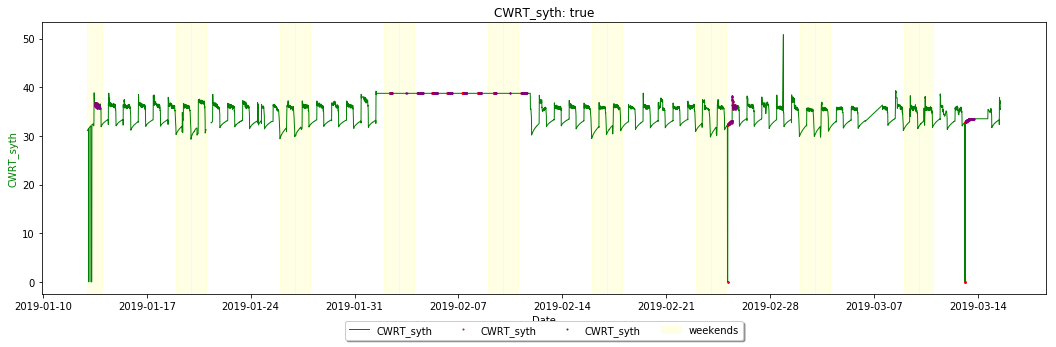

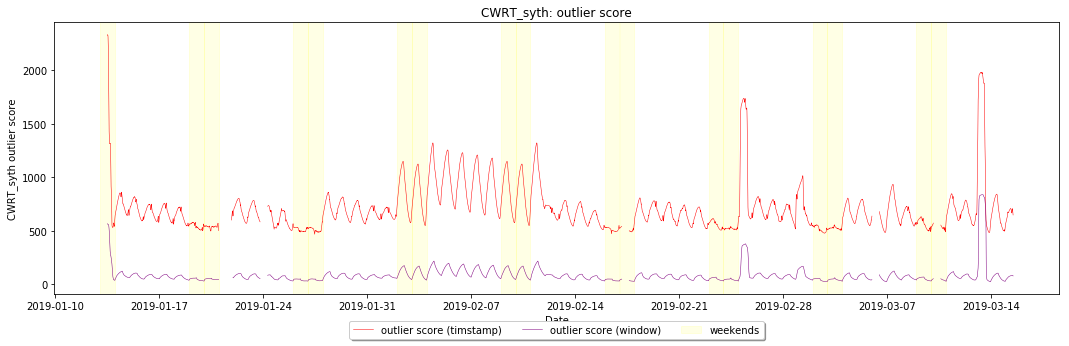

In [34]:
pctoutlier = 0.05

# ------------ outlier score plot ------------------
fig, ax1 = plt.subplots(figsize=(18, 5))

ts_score_cols = ['Score_('+col+')_timstamp_normalized('+m+')' for m in ['mean', 'median']]
wd_score_cols = ['Score_('+col+')_window_normalized('+m+')' for m in ['mae', 'rmse']]
df = data_2[[col]].copy()
df['outlier score (timstamp)'] = data_2[ts_score_cols].mean(axis=1).rolling(144).sum()
df['outlier score (window)'] = data_2[wd_score_cols].mean(axis=1).rolling(144).sum()
thrshold_ts = np.nanpercentile(df['outlier score (timstamp)'].values, (1-pctoutlier)*100)
thrshold_wd = np.nanpercentile(df['outlier score (window)'].values, (1-pctoutlier)*100)
subdf_outlier_ts = df[df['outlier score (timstamp)']>thrshold_ts].copy()
subdf_outlier_wd = df[df['outlier score (window)']>thrshold_wd].copy()

ax1.plot_date(df.index, df[col], 
              c='green',  markersize=0.5,  marker='', linewidth=1, linestyle='-', label=col)
ax1.plot_date(subdf_outlier_ts.index, subdf_outlier_ts[col], 
              c='red',  markersize=2,  marker='.', linewidth=1, linestyle='', label=col)
ax1.plot_date(subdf_outlier_wd.index, subdf_outlier_wd[col], 
              c='purple',  markersize=2,  marker='.', linewidth=1, linestyle='', label=col)
ax1.set_ylabel(col, color='green')
ax1.set_xlabel('Date')

tmp = df.index.to_frame()
tmp['wkday'] = df.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1

plt.title(col+': true')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
plt.show()


fig, ax2 = plt.subplots(figsize=(18, 5))
ax2.plot_date(df.index, df['outlier score (timstamp)'], 
              c='red',  markersize=1,  marker='', linewidth=0.5, linestyle='-', label='outlier score (timstamp)')
ax2.plot_date(df.index, df['outlier score (window)'], 
              c='purple',  markersize=1,  marker='', linewidth=0.5, linestyle='-', label='outlier score (window)')
ax2.set_ylabel(col+' outlier score', color='black')
ax2.set_xlabel('Date')


tmp = df.index.to_frame()
tmp['wkday'] = df.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1

plt.title(col+': outlier score')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
plt.show()

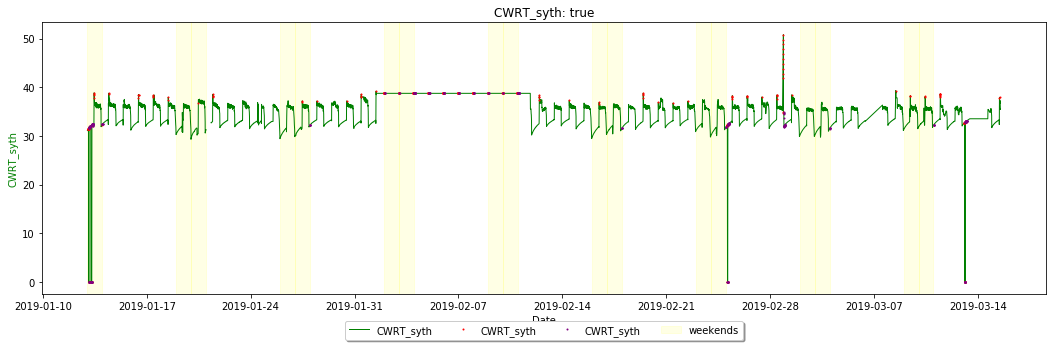

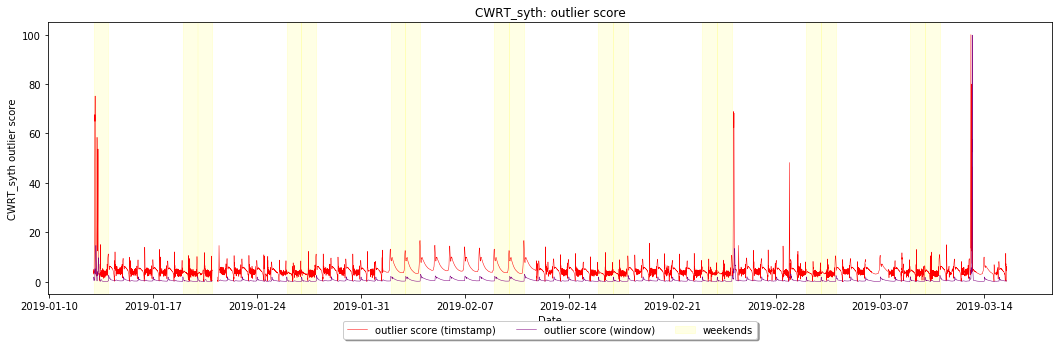

In [35]:
pctoutlier = 0.02

# ------------ outlier score plot ------------------
fig, ax1 = plt.subplots(figsize=(18, 5))

ts_score_cols = ['Score_('+col+')_timstamp_normalized('+m+')' for m in ['mean', 'median']]
wd_score_cols = ['Score_('+col+')_window_normalized('+m+')' for m in ['mae', 'rmse']]
df = data_2[[col]].copy()
df['outlier score (timstamp)'] = data_2[ts_score_cols].mean(axis=1)
df['outlier score (window)'] = data_2[wd_score_cols].mean(axis=1)
thrshold_ts = np.nanpercentile(df['outlier score (timstamp)'].values, (1-pctoutlier)*100)
thrshold_wd = np.nanpercentile(df['outlier score (window)'].values, (1-pctoutlier)*100)
subdf_outlier_ts = df[df['outlier score (timstamp)']>thrshold_ts].copy()
subdf_outlier_wd = df[df['outlier score (window)']>thrshold_wd].copy()

ax1.plot_date(df.index, df[col], 
              c='green',  markersize=0.5,  marker='', linewidth=1, linestyle='-', label=col)
ax1.plot_date(subdf_outlier_ts.index, subdf_outlier_ts[col], 
              c='red',  markersize=2,  marker='.', linewidth=1, linestyle='', label=col)
ax1.plot_date(subdf_outlier_wd.index, subdf_outlier_wd[col], 
              c='purple',  markersize=2,  marker='.', linewidth=1, linestyle='', label=col)
ax1.set_ylabel(col, color='green')
ax1.set_xlabel('Date')

tmp = df.index.to_frame()
tmp['wkday'] = df.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1

plt.title(col+': true')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
plt.show()



fig, ax2 = plt.subplots(figsize=(18, 5))
ax2.plot_date(df.index, df['outlier score (timstamp)'], 
              c='red',  markersize=1,  marker='', linewidth=0.5, linestyle='-', label='outlier score (timstamp)')
ax2.plot_date(df.index, df['outlier score (window)'], 
              c='purple',  markersize=1,  marker='', linewidth=0.5, linestyle='-', label='outlier score (window)')
ax2.set_ylabel(col+' outlier score', color='black')
ax2.set_xlabel('Date')


tmp = df.index.to_frame()
tmp['wkday'] = df.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1

plt.title(col+': outlier score')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
plt.show()

In [59]:
data_2.to_csv('data_3.csv', index=True)